In [ ]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Input

from sklearn.model_selection import train_test_split

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Direktori dataset
TRAIN_DIR = '/content/drive/My Drive/Machine Learning/Tomato/Dataset/train/'
VALIDATION_DIR = '/content/drive/My Drive/Machine Learning/Tomato/Dataset/val/'

In [ ]:
# Cek jumlah gambar di setiap kelas dan simpan dalam dictionary
class_counts = {}
for class_name in os.listdir(TRAIN_DIR):
    class_dir = os.path.join(TRAIN_DIR, class_name)
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))
        class_counts[class_name] = num_images
        print(f"{class_name}: {num_images} gambar")

# Tentukan jumlah gambar terendah
min_images = min(class_counts.values())
print(f"\nJumlah gambar terendah: {min_images}")

Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1000 gambar
Tomato___Tomato_mosaic_virus: 1000 gambar
Tomato___Target_Spot: 1000 gambar
Tomato___Spider_mites Two-spotted_spider_mite: 1000 gambar
Tomato___Septoria_leaf_spot: 1000 gambar
Tomato___healthy: 1000 gambar
Tomato___Bacterial_spot: 1000 gambar
Tomato___Late_blight: 1000 gambar
Tomato___Early_blight: 1000 gambar
Tomato___Leaf_Mold: 1000 gambar

Jumlah gambar terendah: 1000


In [ ]:
# Preprocessing gambar dan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 10000 images belonging to 10 classes.
Found 984 images belonging to 10 classes.


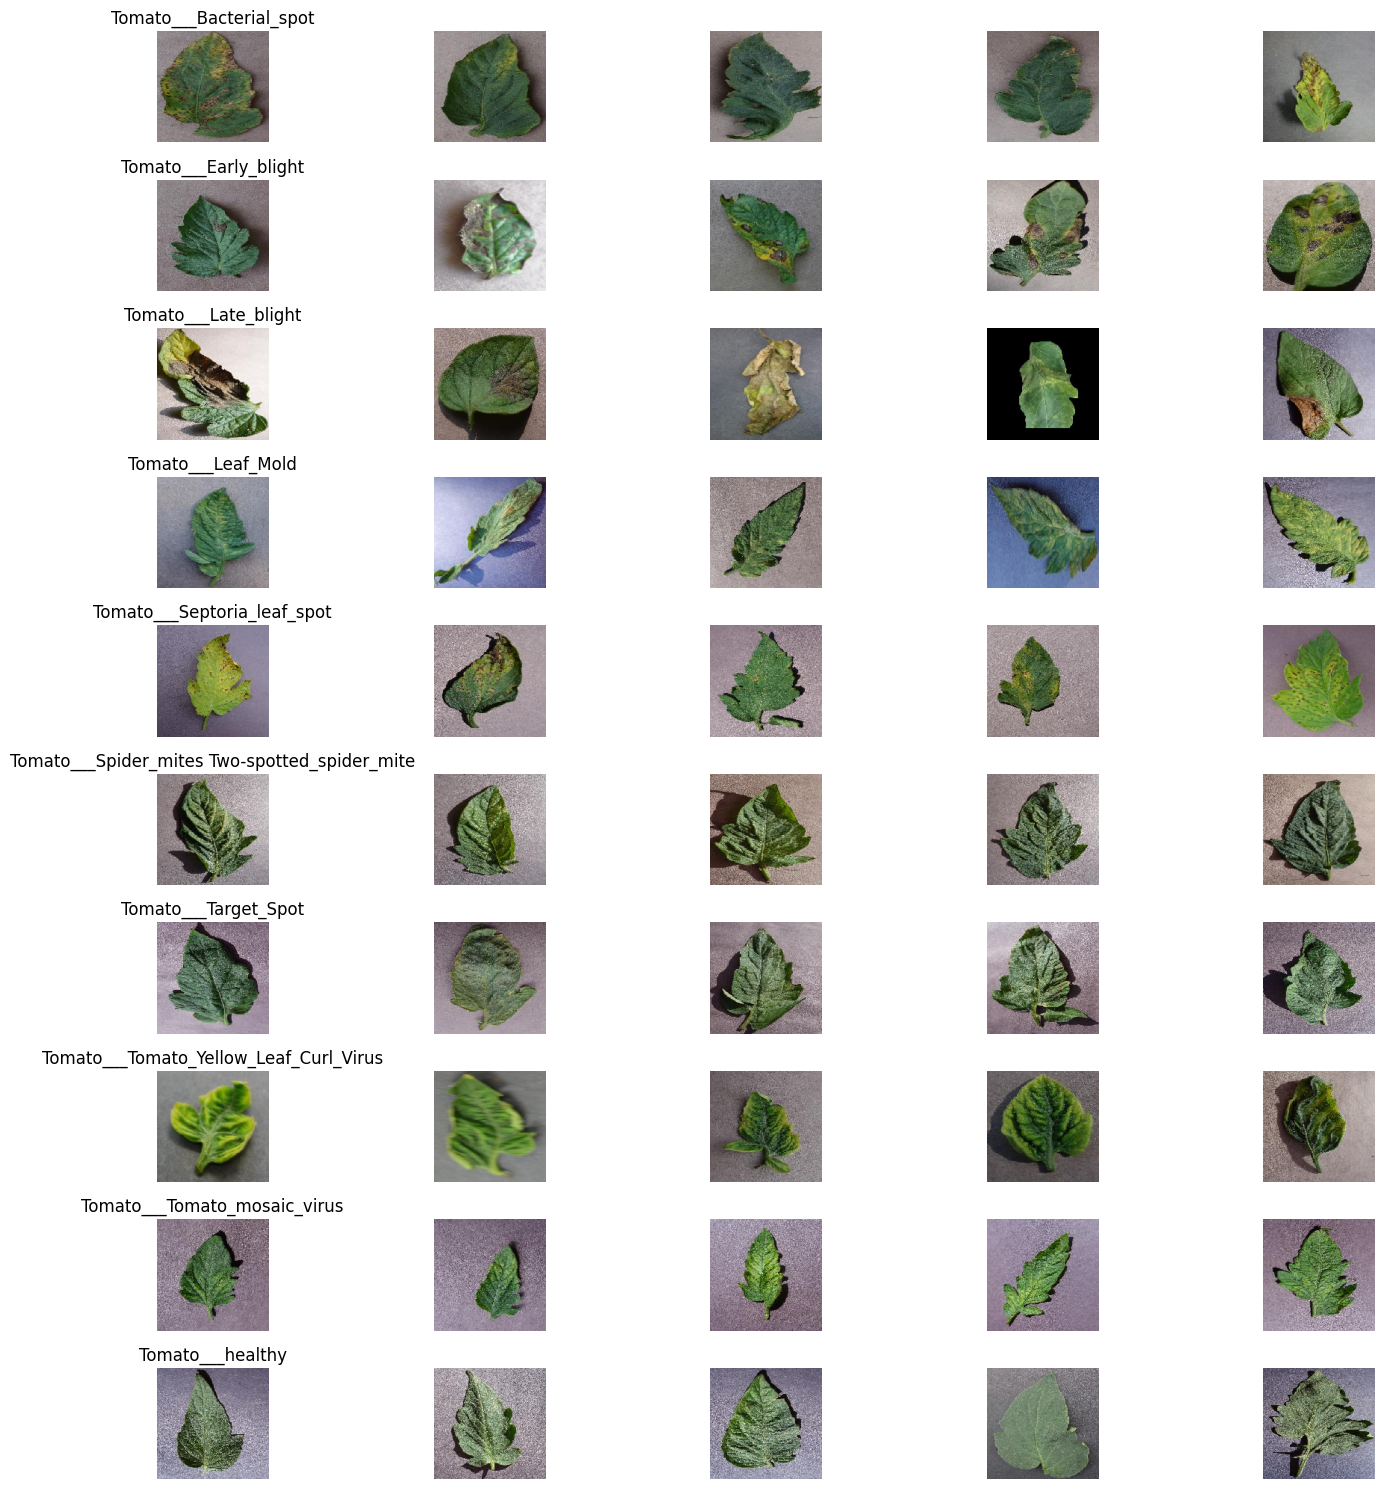

In [ ]:
# Fungsi untuk menampilkan beberapa sampel gambar dari setiap kelas
def display_samples_from_all_classes(directory, class_names, num_samples=5):
    plt.figure(figsize=(15, 15))

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        image_files = os.listdir(class_path)[:num_samples]

        for j, img_file in enumerate(image_files):
            img_path = os.path.join(class_path, img_file)
            img = load_img(img_path, target_size=(150, 150))
            img_array = img_to_array(img) / 255.0

            plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
            plt.imshow(img_array)
            if j == 0:
                plt.title(class_name)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Menampilkan 5 sampel gambar dari setiap kelas
class_names = list(train_generator.class_indices.keys())
display_samples_from_all_classes(TRAIN_DIR, class_names)

In [ ]:
# EarlyStoppingCallback
class EarlyStoppingCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        # Periksa apakah akurasi lebih besar 90%
        # Handle cases where val_accuracy is None
        val_accuracy = logs.get('val_accuracy')
        if val_accuracy is not None and val_accuracy > 0.90:
            # Berhenti melatih model jika kondisi di atas terpenuhi
            self.model.stop_training = True
            print("\nReached >90% val_accuracy so cancelling training!")

In [ ]:
#Membangun model CNN untuk klasifikasi
model = tf.keras.Sequential([
    Input(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Membuat instance dari EarlyStoppingCallback
early_stopping_callback = EarlyStoppingCallback()

In [ ]:
# Melatih model dengan callback
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping_callback]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


312/312 ━━━━━━━━━━━━━━━━━━━━ 4589s 14s/step - accuracy: 0.2950 - loss: 1.9626 - val_accuracy: 0.6990 - val_loss: 0.8507
Epoch 2/30
  1/312 ━━━━━━━━━━━━━━━━━━━━ 8:35 2s/step - accuracy: 0.6875 - loss: 0.9411

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


312/312 ━━━━━━━━━━━━━━━━━━━━ 38s 118ms/step - accuracy: 0.6875 - loss: 0.9411 - val_accuracy: 0.5417 - val_loss: 1.2541
Epoch 3/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 712s 2s/step - accuracy: 0.6809 - loss: 0.8753 - val_accuracy: 0.6885 - val_loss: 0.9516
Epoch 4/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6875 - loss: 0.8717 - val_accuracy: 0.6667 - val_loss: 1.0913
Epoch 5/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 704s 2s/step - accuracy: 0.7893 - loss: 0.6040 - val_accuracy: 0.7052 - val_loss: 0.8952
Epoch 6/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7188 - loss: 0.6479 - val_accuracy: 0.7083 - val_loss: 0.8068
Epoch 7/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 745s 2s/step - accuracy: 0.8094 - loss: 0.5516 - val_accuracy: 0.7979 - val_loss: 0.6611
Epoch 8/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7812 - loss: 0.5487 - val_accuracy: 0.7917 - val_loss: 0.3859
Epoch 9/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 736s 2s/step - accuracy: 0.8453 - loss: 0.4463 - val_accuracy: 0.7542

In [ ]:
# Simpan Model di Google Drive
model_save_path = '/content/drive/My Drive/Machine Learning/Tomato/Tomato_CNN.keras'
model.save(model_save_path)
print(f"Model disimpan sebagai '{model_save_path}'")

Model disimpan sebagai '/content/drive/My Drive/Machine Learning/Tomato/Tomato_CNN.keras'


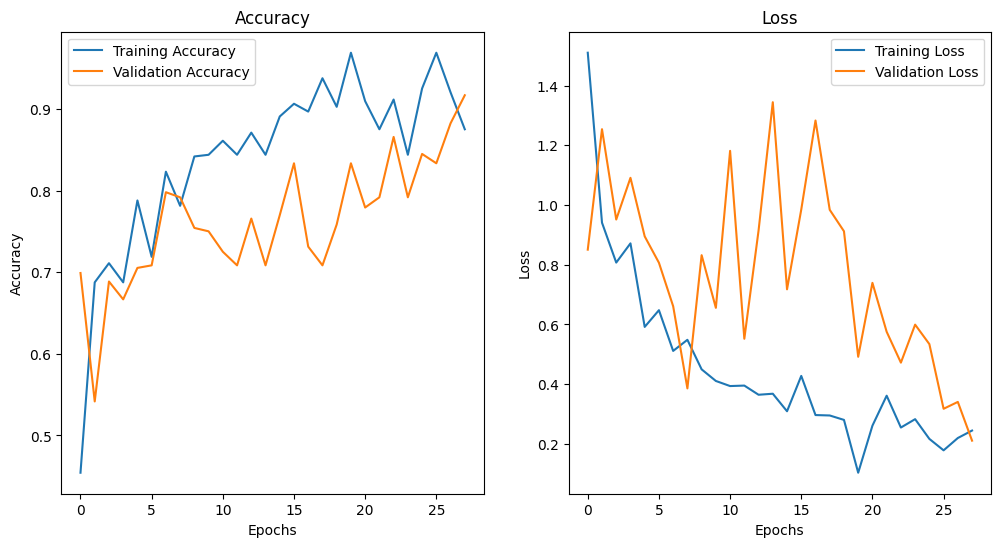

In [ ]:
# Menampilkan grafik akurasi dan loss
plt.figure(figsize=(12, 6))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()